In [1]:
import sys
sys.path.append('../python') #Path to load WI_Solver_Utils.py
import WI_Solver_utils
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import trange
from WI_Solver_utils import InflatonModel, Background, Perturbations, Growth_factor
matplotlib.rcParams.update({'errorbar.capsize': 2})
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')

def format_fit_pars(pars, mode='complex'):
    global formatted_pars
    if mode=='complex':
        formatted_pars=[r'$b_1=',r'$b_2=',r'$b_3=',r'$b_4=',r'$b_5=',r'$b_6=',r'$a_1=,',r'$a_2=',r'$a_3=',r'$a_4=',r'$a_5=',r'$a_6=']
    if mode=='simple':
        formatted_pars=[r'$\alpha=',r'$\beta=',r'$A=',r'$B=']
    for i in range(len(pars)):
        pv=pars[i]
        exp = math.floor(math.log10(abs(pv))) # automatically detect the value of c
        if (exp>=1) or (exp<=-2):
            formatted_pv = "{:.2f}⋅10^{{{}}}".format(pv / 10**exp, exp)
        else:
            formatted_pv = "{:.2f}".format(pv)
        #Add formatted_pv to the ith element of formatted_pars, before the last $ sign:
        formatted_pars[i]=formatted_pars[i]+formatted_pv+'$'
    #Return as a single string of two columns with commas between the elements:
    return ', '.join(formatted_pars[:len(pars)//2])+'\n '+', '.join(formatted_pars[len(pars)//2:])

In [5]:
####################################################################
#   Define tau array over which we solved for the perturbations:   #
####################################################################
"""Recall: \tau=\ln(z)=\ln(k/(aH))"""

tau_ini = 6
tau_end = -1
N = 100000
dtau = (tau_end - tau_ini) / N # DT is a negative quantity as expected since tau is decreasing over time
taus = np.linspace(tau_ini, tau_end, N)


#################################
#   Define Global Parameters:   #
#################################

Mpl = 1 # Everything is in Plank units M_{pl}
g = 228.27  # SUSY relativistic degrees of freedom
a1 = np.pi**2/30*g

Neinflation=60 #Number of e-folds of inflation
Nruns=1024 #How many runs did we average over to compute the perturbations
MPs_bool='wo' #without metric perturbations
epsH_etaH_bool='wo' #negligible epsH and etaH

cm_cases=[[3,2],[3,0],[-1,0],[-1,2]]


In [3]:
#######################################################################
#   Define the type of inflaton potential and its main parammeters:   #
#######################################################################

potential_type='quartic'

lv = 10**(-14)  # value of lambda

Model = InflatonModel('monomial', [lv, 4], g, a1, Mpl)


################################################
#   Initial conditions on \phi0 and Q array:   #
################################################

"""
Note here we load previously computed initial conditions that guarantee N_e= Neinflation + 8 efolds of inflation.
To see how these were computed, check out the notebook "ICs_ph0.ipynb"
"""

ICs_Q0_ph0=np.loadtxt('../ICS_ph0-Q0s/ICS_ph0-Q0s_'+potential_type+'_Ne'+str(int(Neinflation))+'.txt')
Q0s=ICs_Q0_ph0[:,0]
ph0s=ICs_Q0_ph0[:,1]

########################################################################
#   Compute the Analytic approximation of the Power spectrum for c=0   #
########################################################################

R2_analytic=np.zeros(len(Q0s))
for i in trange(len(Q0s)):
    Bg=Background(Model,ph0s[i],Q0s[i])
    R2_analytic[i]=Bg.analytic_power_spectrum(int(Neinflation+11), 10**(6), taus, Neinflation)
    del Bg



100%|███████████████████████████████████████████| 52/52 [00:51<00:00,  1.01it/s]


In [6]:
R2m_list, R2std_list=[],[]
for i in trange(len(cm_cases)):
    cval=cm_cases[i][0]
    mval=cm_cases[i][1]
    _,R2m,R2std=np.loadtxt('../WI_PowerSpectra_data/PowerSpectra_'+str(MPs_bool)+'MPs_'+str(epsH_etaH_bool)+'epsH-etaH_'+potential_type+'_c'+str(cval)+'m'+str(mval)+'_n'+str(int(N))+'_Nr'+str(int(Nruns))+'_Ne'+str(int(Neinflation))+'.txt')
    R2m_list.append(R2m)
    R2std_list.append(R2std)
    del R2m, R2std
R2m_list=np.array(R2m_list)
R2std_list=np.array(R2std_list)

100%|███████████████████████████████████████████| 4/4 [00:00<00:00, 2006.60it/s]


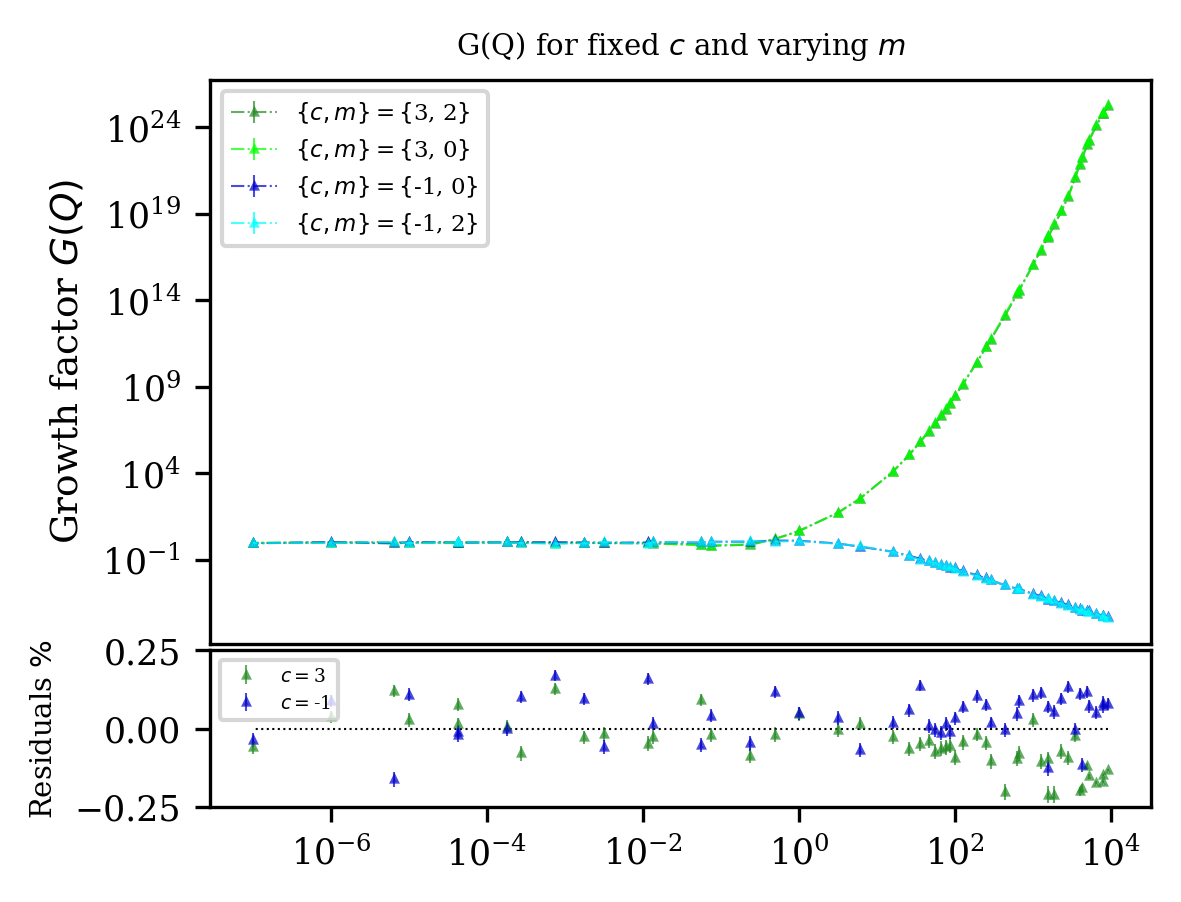

In [18]:
#Make Figure where I plot the data and the fit:
fig1=plt.figure(figsize=(4.5,3.5),dpi=300)
gs1 = GridSpec(20,20,figure=fig1)
ax1 = fig1.add_subplot(gs1[1:15,1:-1])
ax2 = fig1.add_subplot(gs1[15:-1,1:-1])


##############################
# Useful for general legend: #
##############################
cm_cols=['forestgreen','lime','mediumblue','cyan']
ax1.set_xlabel("$Q$",fontdict={'fontsize':9,'family':'serif'})
ax1.set_ylabel("Growth factor $G(Q)$",fontdict={'fontsize':9,'family':'serif'})
ax2.set_ylabel("Residuals $\%$",fontdict={'fontsize':7,'family':'serif'})
ax1.set_title(r"G(Q) for fixed $c$ and varying $m$",fontdict={'fontsize':7,'family':'serif'})
GQ_sig_list,GQ_err_list=[],[]
for i in range(len(cm_cases)):
    Gf=Growth_factor(Model,Q0s,ph0s,R2m_list[i],R2std_list[i],Nruns,int(Neinflation+11),10**(6),taus,Neinflation,cm_cases[i][0],cm_cases[i][1])
    _,_,GQ_sig,GQ_err=Gf.growth_factor_fit(method='simple',output_data=True,analytic_power_spectrum=True, deltaR2_analytic=R2_analytic)
    GQ_sig_list.append(GQ_sig)
    GQ_err_list.append(GQ_err)
    ax1.errorbar(Q0s,GQ_sig,yerr=GQ_err,c=cm_cols[i],marker='^',ls='-.',markersize=1,linewidth=0.5, alpha=.7,label="$\{c,m\}=\{$"+str(int(cm_cases[i][0]))+', '+str(int(cm_cases[i][1]))+'$\}$')            
    del Gf,GQ_sig,GQ_err
ax2.errorbar(Q0s,(GQ_sig_list[0]-GQ_sig_list[1])/(GQ_sig_list[0]),yerr=1/(GQ_sig_list[0])**2*np.sqrt((GQ_sig_list[1]*GQ_err_list[0])**2+(GQ_sig_list[0]*GQ_err_list[1])**2),c=cm_cols[0],marker='^',ls='none',markersize=1,linewidth=0.5, alpha=.7,label="$c=$"+str(int(cm_cases[0][0])))            
ax2.errorbar(Q0s,(GQ_sig_list[2]-GQ_sig_list[3])/(GQ_sig_list[2]),yerr=1/(GQ_sig_list[2])**2*np.sqrt((GQ_sig_list[3]*GQ_err_list[2])**2+(GQ_sig_list[2]*GQ_err_list[3])**2),c=cm_cols[2],marker='^',ls='none',markersize=1,linewidth=0.5, alpha=.7,label="$c=$"+str(int(cm_cases[2][0])))            
ax2.plot(Q0s,np.zeros(len(Q0s)),ls=':',linewidth=0.5,c='k')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xticks(ticks=[])
ax2.set_xscale('log')
ax2.set_ylim(-0.25,0.25)
ax1.legend(prop={'family':'serif','size':5.5},framealpha=0.8)
ax2.legend(prop={'family':'serif','size':4.5},framealpha=0.8)
plt.show()